## Classifier Baseline

В этом ноутбуке производится обучение классификатора, который по изображению коктейля предсказывает набор ингредиентов.

In [41]:
from pprint import pprint
import random
from PIL import Image
import json

import pickle
import math
from glob import glob
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from openvino.runtime import Core
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
import timm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
sns.set(style='darkgrid', font_scale=1.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
random.seed(0)
np.random.seed(0)

cuda


### Подготовка данных для обучения:

Получаем список коктейлей (наименование коктейля соответствует наименованию каталога)

In [42]:
cockt_list = glob('/home/maksim/Cocktails/Images/Coctails_raw/*', )
cockt_list = sorted([x[43:] for x in cockt_list])

Читаем из конфига (json заполняется руками) наименования ингредиентов на двух языках.

In [43]:
# Opening ingredients JSON config
with open('config/ingredients.json', 'r') as f:
    ingedients_config = json.load(f)

class_labels = ingedients_config["idx"]
id2rus_genitive = ingedients_config["id2rus_genitive"]
class_labels_ru = np.array([id2rus_genitive[idx] for idx in class_labels])

class_dict = dict()
for i in range(len(class_labels)):
    class_dict[class_labels[i]] = i

Проверяем, что русскоязычные наименования соответствуют идентификаторам.

In [44]:
for idx, rus in zip(class_labels, class_labels_ru):
    print(idx, ' = ', rus)

orange_juice  =  апельсиновый сок
pinapple_juice  =  ананасовый сок
cranberry_juice  =  клюквенный сок
tomato_juice  =  томатный сок
tonic  =  тоник
energy  =  энергетик
sprite  =  спрайт
cola  =  колу
wine  =  красное вино
whiskey  =  виски
vodka  =  водку
gin  =  джин
rum  =  ром
tequila  =  текилу
lemon_juice  =  сок лимона или лайма
blue_curacao  =  ликёр Blue Curacao
coffee_liq  =  кофейный ликёр
irish_cream  =  сливочный ликёр "irish cream"
orange_liq  =  апельсиновый ликёр
peach_liq  =  персиковый ликёр
coconut_liq  =  кокосовый ликёр
blackcurrant_liq  =  смородиновый или вишнёвый ликёр
red_bitter  =  красный биттер
vermouth  =  вермут
coconut_syr  =  кокосовый сироп
grenadine  =  сироп Гренадин
sugar_syr  =  сахарный сироп
beer  =  пиво
lemon  =  лимон
lime  =  лайм
mint  =  мяту
orange_peel  =  корку или дольку апельсина для украшения
strawberry  =  клубнику
tea  =  чай
coffee  =  кофе
milk  =  молоко
cream  =  сливки
chocolate  =  шоколад
ice_cream  =  мороженное
tabasco  =  

Читаем из конфига (json заполняется руками) рецепты коктейлей.

In [46]:
# Opening recipes JSON config
with open('config/recipes.json', 'r') as f:
    text_recipes = json.load(f)

Проверяем, что перечень ингредиентов в двух конфигах совпадает:

In [47]:
ing_set = set()
for rec in text_recipes:
    ing_set.update(text_recipes[rec])
    
print(all(a == b for a, b in zip(sorted(ing_set), sorted(class_labels))))
print(len(ing_set) == len(class_labels))

True
True


Проверяем, что список коктейлей в каталоге совпадает со списком в конфиге:

In [48]:
print(all(folder == conf for folder, conf in zip(cockt_list, text_recipes.keys())))
print(len(cockt_list) == len(text_recipes))

True
True


Формируем векторные представления рецептов.

In [49]:
recipes = dict()
for cocktail, recipe in text_recipes.items():
    arr = torch.zeros(len(class_labels), dtype=torch.int)
    arr[[class_dict[ingr] for ingr in recipe]] = 1
    recipes[cocktail] = arr

Задаём размер изображения, каталог с изображениями (убучающей выборкой) и константы нормализации:

In [50]:
# Opening model JSON config
with open('config/model.json', 'r') as f:
    model_conf = json.load(f)

In [51]:
image_size = model_conf['image_size']
crop_size = model_conf['crop_size']
DATA_DIR = '/home/maksim/Cocktails/Images/Coctails_raw/'
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
print(f'Imge size = {image_size}x{image_size}')
print(f'Crop size = {crop_size}x{crop_size}')

Imge size = 160x160
Crop size = 180x180


In [52]:
def show_generated_images(generated):
    clear_output(wait=True)
    plt.figure(figsize=(24, 8))
    for k in range(len(generated)):
        plt.subplot(1, len(generated), k+1)
        plt.imshow(denorm(np.rollaxis(generated[k].numpy(), 0, 3)))
        plt.axis('off')
    plt.show()

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=200):
    fig, ax = plt.subplots(figsize=(60, 60))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [69]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for batch in self.dataloader: 
            yield to_device(batch, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

    
def get_dataloaders(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DeviceDataLoader object 
    """
  
    full_set = ImageFolder(DATA_DIR, 
                           transform=tt.Compose([
                                  tt.Resize(crop_size),
                                  tt.CenterCrop(crop_size),
                                  tt.ColorJitter(brightness=(0.8, 1.1), 
                                                 contrast=(0.8, 1.1), 
                                                 saturation=(0.8, 1.1), 
                                                 hue=0.015),
                                  tt.ToTensor(),
                                  tt.Normalize(*stats),
                                  tt.RandomCrop(image_size),
                                  tt.RandomHorizontalFlip() ])
                               )
    
    recipe_labels = torch.zeros((len(full_set.classes), len(class_labels)))
    for cockt, idx in full_set.class_to_idx.items():
        recipe_labels[idx] = recipes[cockt]
    
    
    n = len(full_set)  
    n_test = int(0.2 * n)  
    permutation = list(range(n))
    random.Random(42).shuffle(permutation)
    train_set = torch.utils.data.Subset(full_set, permutation[n_test: n])  
    test_set = torch.utils.data.Subset(full_set, permutation[:n_test])  
    
    train_dataloader = DataLoader(train_set, batch_size, shuffle=True, num_workers=5, pin_memory=True)
    test_dataloader = DataLoader(test_set, batch_size, shuffle=True, num_workers=5, pin_memory=True)

    return DeviceDataLoader(train_dataloader, device), DeviceDataLoader(test_dataloader, device), recipe_labels

Взглянем на аугментированные изображения:

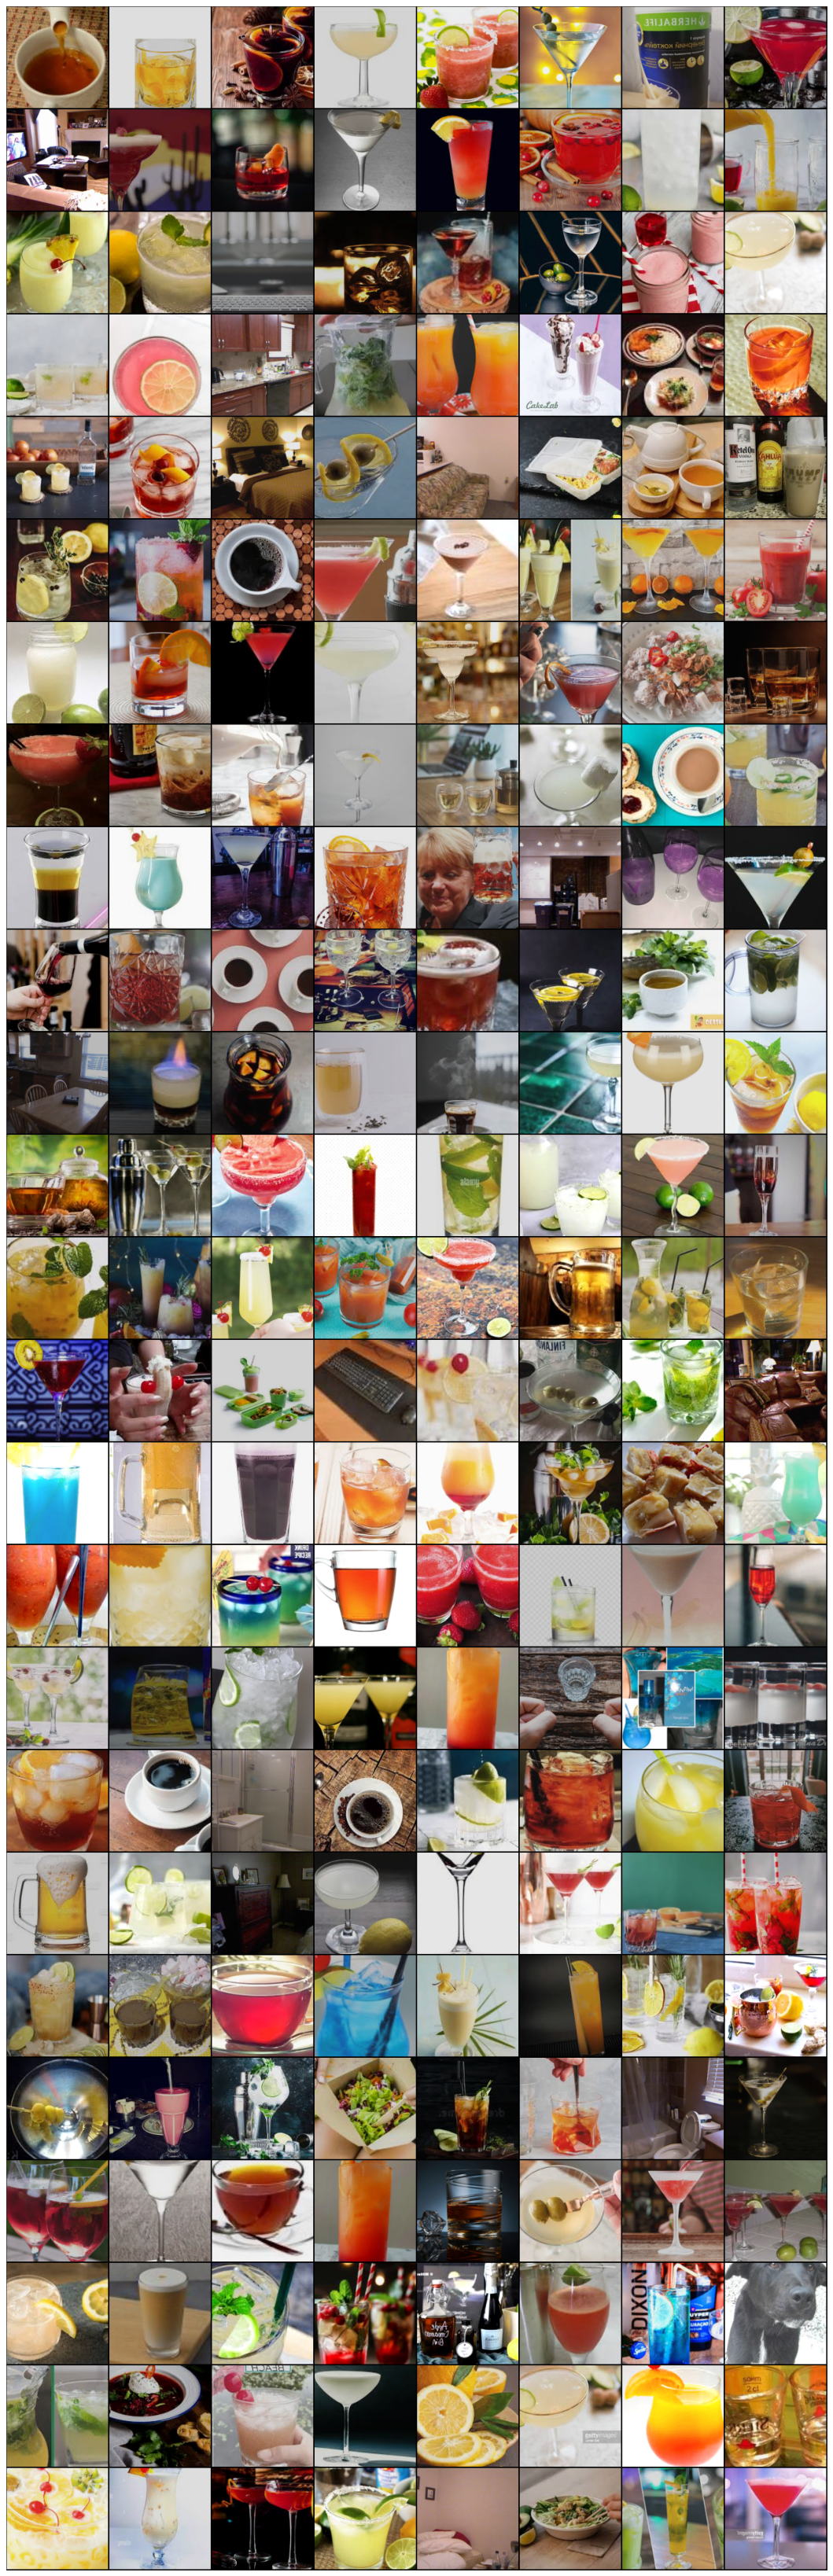

In [71]:
batch_size = 200
train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
show_images(next(iter(val_loader))[0].cpu())

### Обучение нейронной сети.

In [72]:
def fit_epoch(model, train_loader, criterion, optimizer, sheduler, threshold=0.5):
    running_loss = 0.0
    running_recall = 0
    running_precision = 0
    processed_data = 0
  
    for inputs, labels_idx in train_loader:
        inputs = inputs.to(device)
        labels = recipe_labels[labels_idx]
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = (outputs > threshold) * 1
        running_loss += loss.item() * inputs.size(0)
        running_recall += (torch.sum(preds.data * labels.data) + 0.1) / (torch.sum(labels.data) + 0.1) * inputs.size(0)
        running_precision += (torch.sum(preds.data * labels.data) + 0.1) / (torch.sum(preds.data) + 0.1) * inputs.size(0)
        processed_data += inputs.size(0)
    sheduler.step()
    train_loss = running_loss / processed_data
    recall = running_recall.double() / processed_data
    precision = running_precision.double() / processed_data
    train_acc = (2*recall*precision) / (precision+recall) 
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion, threshold=0.5):
    model.eval()
    running_loss = 0.0
    running_recall = 0
    running_precision = 0
    processed_size = 0

    for inputs, labels_idx in val_loader:
        inputs = inputs.to(device)
        labels = recipe_labels[labels_idx]
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = (outputs > threshold) * 1

        running_loss += loss.item() * inputs.size(0)
        running_recall += (torch.sum(preds.data * labels.data) + 0.1) / (torch.sum(labels.data) + 0.1) * inputs.size(0)
        running_precision += (torch.sum(preds.data * labels.data) + 0.1) / (torch.sum(preds.data) + 0.1) * inputs.size(0)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    recall = running_recall.double() / processed_size
    precision = running_precision.double() / processed_size
    val_acc = (2*recall*precision) / (precision+recall) 
    return val_loss, val_acc

def train(train_loader, val_loader, model, epochs, optimizer, gamma=0.95):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        sheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
        criterion = nn.BCEWithLogitsLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, sheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    return history


def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = torch.sigmoid(torch.cat(logits), dim=-1).numpy()
    return probs


def eval_model(model, val_loader):
    with torch.no_grad():
        logits = []
        labels = [] 
    
        for inputs, labels_b in val_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            labels.append(labels_b)
            
    probs = torch.sigmoid(torch.cat(logits), dim=-1).numpy()
    return probs, labels

В качестве нейронной сети для обучения выбрана предобученная MobilenetV3. \
Немного меняем структуру сети: 
1. Послендий полносвязный слой заменяем двумя слоями, bottleneck размерности 14 и финальный классификатор с размерностью, равной количеству ингредиентов.
2. Немного уменьшаем размерность 6-го блока для того, чтобы снизить сложность сети и увеличить её стойкость к переобучению.

In [73]:
model = timm.create_model('mobilenetv3_large_100_miil', pretrained=True).to(device) 

model.classifier = nn.Sequential(
    nn.Linear(in_features=256, out_features=16, bias=False),
    nn.BatchNorm1d(16),
    nn.Linear(in_features=16, out_features=len(class_labels))).to(device)

model.blocks[6][0].conv = nn.Conv2d(160, 256, 1, 1).to(device)
model.blocks[6][0].bn1 = nn.BatchNorm2d(256).to(device)
model.conv_head = nn.Conv2d(256, 256, 1, 1).to(device)

for name, param in model.named_parameters():
    param.requires_grad_(False)

Поучившаяся структура модели:

In [74]:
model

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Hardswish()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

Размораживаем часть градиентов:

In [75]:
#model.blocks[1].requires_grad_(True)
model.blocks[2].requires_grad_(True)
model.blocks[3].requires_grad_(True)
model.blocks[4].requires_grad_(True)
model.blocks[5].requires_grad_(True)
model.blocks[6].requires_grad_(True)

model.conv_head.requires_grad_(True)
model.classifier.requires_grad_(True)

for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv_stem.weight False
bn1.weight False
bn1.bias False
blocks.0.0.conv_dw.weight False
blocks.0.0.bn1.weight False
blocks.0.0.bn1.bias False
blocks.0.0.conv_pw.weight False
blocks.0.0.bn2.weight False
blocks.0.0.bn2.bias False
blocks.1.0.conv_pw.weight False
blocks.1.0.bn1.weight False
blocks.1.0.bn1.bias False
blocks.1.0.conv_dw.weight False
blocks.1.0.bn2.weight False
blocks.1.0.bn2.bias False
blocks.1.0.conv_pwl.weight False
blocks.1.0.bn3.weight False
blocks.1.0.bn3.bias False
blocks.1.1.conv_pw.weight False
blocks.1.1.bn1.weight False
blocks.1.1.bn1.bias False
blocks.1.1.conv_dw.weight False
blocks.1.1.bn2.weight False
blocks.1.1.bn2.bias False
blocks.1.1.conv_pwl.weight False
blocks.1.1.bn3.weight False
blocks.1.1.bn3.bias False
blocks.2.0.conv_pw.weight True
blocks.2.0.bn1.weight True
blocks.2.0.bn1.bias True
blocks.2.0.conv_dw.weight True
blocks.2.0.bn2.weight True
blocks.2.0.bn2.bias True
blocks.2.0.se.conv_reduce.weight True
blocks.2.0.se.conv_reduce.bias True
blocks.2.0.se.c

Для того чтобы максимально сохранить информацию в предобученной сети, устанавливаем разные скорости обучения для различных групп слоёв: чем ближе в выходу сети, тем выше скорость обучения. Вводим новый гиперпараметр lr_decay, который определяет, насколько будут отличаться веса на разных уровнях.

In [76]:
def get_optimizer(lr: float, lr_decay: float) -> object:
    optimizer = torch.optim.Adam([
        {'params': model.conv_stem.parameters()},
        {'params': model.bn1.parameters()},
        {'params': model.blocks[0].parameters(), 'lr': lr/lr_decay**7},
        {'params': model.blocks[1].parameters(), 'lr': lr/lr_decay**6},
        {'params': model.blocks[2].parameters(), 'lr': lr/lr_decay**5},
        {'params': model.blocks[3].parameters(), 'lr': lr/lr_decay**4},
        {'params': model.blocks[4].parameters(), 'lr': lr/lr_decay**3},
        {'params': model.blocks[5].parameters(), 'lr': lr/lr_decay**2},
        {'params': model.blocks[6].parameters(), 'lr': lr/lr_decay**1},
        {'params': model.conv_head.parameters(), 'lr': lr/lr_decay**1},
        {'params': model.classifier.parameters(), 'lr': lr},
    ], lr=lr/lr_decay**8)
    return optimizer
    

Обучаем сеть в несколько циклов с различными значениями lr, lr_decay, batch_size:

In [77]:
lr = 5.0e-3
lr_decay = 6.0
batch_size = 200

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history1 = train(train_loader, val_loader, model=model, epochs=4, optimizer=optimizer, gamma=0.9)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 0.3977806221886659

Epoch 001 train_loss: 0.3978     val_loss 0.1699 train_acc 0.4116 val_acc 0.4816
loss 0.13125363762742245

Epoch 002 train_loss: 0.1313     val_loss 0.1256 train_acc 0.6563 val_acc 0.7035
loss 0.10201947324922114

Epoch 003 train_loss: 0.1020     val_loss 0.1120 train_acc 0.7416 val_acc 0.7221
loss 0.08700292342471605

Epoch 004 train_loss: 0.0870     val_loss 0.1096 train_acc 0.7853 val_acc 0.7521


In [78]:
lr = 3.5e-3
lr_decay = 2.3
batch_size = 80

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history2 = train(train_loader, val_loader, model=model, epochs=5, optimizer=optimizer, gamma=0.9)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 0.11541680108359355

Epoch 001 train_loss: 0.1154     val_loss 0.1177 train_acc 0.7040 val_acc 0.7180
loss 0.0944651758650644

Epoch 002 train_loss: 0.0945     val_loss 0.1078 train_acc 0.7669 val_acc 0.7410
loss 0.08063902108969553

Epoch 003 train_loss: 0.0806     val_loss 0.0998 train_acc 0.8056 val_acc 0.7695
loss 0.06684092553431809

Epoch 004 train_loss: 0.0668     val_loss 0.0958 train_acc 0.8413 val_acc 0.7797
loss 0.057897200995502204

Epoch 005 train_loss: 0.0579     val_loss 0.1029 train_acc 0.8648 val_acc 0.8043
loss 0.05139762245752586

Epoch 006 train_loss: 0.0514     val_loss 0.1092 train_acc 0.8802 val_acc 0.7932


In [79]:
lr = 3.5e-3
lr_decay = 2.2
batch_size = 64

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history3 = train(train_loader, val_loader, model=model, epochs=5, optimizer=optimizer, gamma=0.9)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.07474244634213467

Epoch 001 train_loss: 0.0747     val_loss 0.1127 train_acc 0.8238 val_acc 0.7398
loss 0.0671231246990305

Epoch 002 train_loss: 0.0671     val_loss 0.1048 train_acc 0.8449 val_acc 0.7824
loss 0.05552376046478205

Epoch 003 train_loss: 0.0555     val_loss 0.1068 train_acc 0.8723 val_acc 0.7715
loss 0.04940145753795146

Epoch 004 train_loss: 0.0494     val_loss 0.1066 train_acc 0.8869 val_acc 0.7902
loss 0.04216028638872323

Epoch 005 train_loss: 0.0422     val_loss 0.1028 train_acc 0.9045 val_acc 0.8030


In [80]:
lr = 3.5e-3
lr_decay = 2.0
batch_size = 64

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history4 = train(train_loader, val_loader, model=model, epochs=3, optimizer=optimizer, gamma=0.85)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 0.08458108011669024

Epoch 001 train_loss: 0.0846     val_loss 0.1156 train_acc 0.8029 val_acc 0.7566
loss 0.07362757495975482

Epoch 002 train_loss: 0.0736     val_loss 0.1137 train_acc 0.8323 val_acc 0.7568
loss 0.0599189628044547

Epoch 003 train_loss: 0.0599     val_loss 0.1031 train_acc 0.8623 val_acc 0.7979
loss 0.04187686572759188

Epoch 004 train_loss: 0.0419     val_loss 0.1147 train_acc 0.9061 val_acc 0.7912


In [81]:
lr = 5.0e-3 
lr_decay = 2.6 
batch_size = 200

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history5 = train(val_loader, val_loader, model=model, epochs=10, optimizer=optimizer, gamma=0.85) 

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.09789757480192948

Epoch 001 train_loss: 0.0979     val_loss 0.0688 train_acc 0.7750 val_acc 0.8334
loss 0.06408252131466118

Epoch 002 train_loss: 0.0641     val_loss 0.0510 train_acc 0.8521 val_acc 0.8860
loss 0.050016526192544576

Epoch 003 train_loss: 0.0500     val_loss 0.0451 train_acc 0.8856 val_acc 0.8947
loss 0.05754932852792735

Epoch 004 train_loss: 0.0575     val_loss 0.0439 train_acc 0.8678 val_acc 0.8988
loss 0.041651241979541384

Epoch 005 train_loss: 0.0417     val_loss 0.0334 train_acc 0.9033 val_acc 0.9240
loss 0.03257537537645159

Epoch 006 train_loss: 0.0326     val_loss 0.0280 train_acc 0.9259 val_acc 0.9374
loss 0.02651506211424827

Epoch 007 train_loss: 0.0265     val_loss 0.0230 train_acc 0.9399 val_acc 0.9472
loss 0.024337014075203438

Epoch 008 train_loss: 0.0243     val_loss 0.0216 train_acc 0.9454 val_acc 0.9501
loss 0.022505459528282215

Epoch 009 train_loss: 0.0225     val_loss 0.0192 train_acc 0.9499 val_acc 0.9568
loss 0.019216015846135963

Epoch 

In [82]:
lr = 3.5e-3
lr_decay = 2.2
batch_size = 64

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history6 = train(train_loader, val_loader, model=model, epochs=4, optimizer=optimizer, gamma=0.85)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 0.05905114849144799

Epoch 001 train_loss: 0.0591     val_loss 0.0851 train_acc 0.8690 val_acc 0.8190
loss 0.05020975164958595

Epoch 002 train_loss: 0.0502     val_loss 0.0818 train_acc 0.8867 val_acc 0.8294
loss 0.03848855734993991

Epoch 003 train_loss: 0.0385     val_loss 0.0850 train_acc 0.9140 val_acc 0.8398
loss 0.030468068052700744

Epoch 004 train_loss: 0.0305     val_loss 0.0772 train_acc 0.9325 val_acc 0.8478


In [83]:
lr = 3.5e-3 
lr_decay = 3.5 
batch_size = 200

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history6 = train(val_loader, val_loader, model=model, epochs=8, optimizer=optimizer, gamma=0.9) 

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 0.06898120949333741

Epoch 001 train_loss: 0.0690     val_loss 0.0488 train_acc 0.8485 val_acc 0.8846
loss 0.04765847770839638

Epoch 002 train_loss: 0.0477     val_loss 0.0395 train_acc 0.8901 val_acc 0.9083
loss 0.0379688555412359

Epoch 003 train_loss: 0.0380     val_loss 0.0312 train_acc 0.9148 val_acc 0.9306
loss 0.031414358780372055

Epoch 004 train_loss: 0.0314     val_loss 0.0258 train_acc 0.9293 val_acc 0.9427
loss 0.02618924261887319

Epoch 005 train_loss: 0.0262     val_loss 0.0220 train_acc 0.9390 val_acc 0.9496
loss 0.022442439348226893

Epoch 006 train_loss: 0.0224     val_loss 0.0197 train_acc 0.9502 val_acc 0.9545
loss 0.019832129057897392

Epoch 007 train_loss: 0.0198     val_loss 0.0163 train_acc 0.9546 val_acc 0.9635
loss 0.0175498954727028

Epoch 008 train_loss: 0.0175     val_loss 0.0147 train_acc 0.9598 val_acc 0.9670


In [84]:
lr = 1e-3 #1.5e-3
lr_decay = 2.5 
batch_size = 200

train_loader, val_loader, recipe_labels = get_dataloaders(image_size, batch_size)
optimizer = get_optimizer(lr, lr_decay)

history7 = train(train_loader, val_loader, model=model, epochs=1, optimizer=optimizer, gamma=0.5) 

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

loss 0.02133520107992956

Epoch 001 train_loss: 0.0213     val_loss 0.0248 train_acc 0.9538 val_acc 0.9435


Сохраняем модель, веса. При необходимости, загружаем веса.

In [85]:
torch.save(model.state_dict(), 'classifier_state_dict.pt')
torch.save(model, 'classifier_model.pt')

In [86]:
model.load_state_dict(torch.load('classifier_state_dict.pt'))

<All keys matched successfully>

Проверим работу модели на случайном изображении:

In [87]:
def predict_ingredients(path: str, model: callable, classes: np.array) -> list:
    try:
        image = Image.open(path)
    except:
        return []
    width, height = image.size  # Get dimensions
    size = min(width, height)
    

    left = (width - size) / 2
    top = (height - size) / 2
    right = (width + size) / 2
    bottom = (height + size) / 2

    # Crop the center of the image
    image = image.crop((left, top, right, bottom))
    img = np.asarray(image.resize((image_size, image_size))) / 127.5 - 1.0
    
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(denorm(img))
    plt.axis('off')
    plt.show()
    
    logits = model(torch.tensor(np.rollaxis(img, 2, 0)[None, :, :, :], dtype=torch.float).to(device))
    result = (logits.detach().cpu() > 0).nonzero()[:, 1].numpy()
    return classes[result]

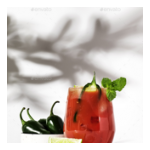

array(['томатный сок', 'водку', 'сок лимона или лайма',
       'острый соус из красного перца', 'соль', 'сельдерей'], dtype='<U40')

In [88]:
predict_ingredients('/home/maksim/Cocktails/Images/Coctails_raw/Bloody_mary/AD4A0735.jpg', model, class_labels_ru)

### Конвертация в ONNX

Загружаем модель в pytorch и экспортируем в формат ONNX.

In [89]:
model.to('cpu')
model.load_state_dict(torch.load('classifier_state_dict.pt'))
# Evaluate the model to switch some operations from training mode to inference.
model.eval()
# Create dummy input for the model. It will be used to run the model inside export function.
dummy_input = torch.randn(1, 3, image_size, image_size)
# Call the export function
torch.onnx.export(model,               
                  dummy_input,                         
                  'classifier.onnx',   
                  export_params=True,        
                  opset_version=11,          
                  do_constant_folding=True,  
                  input_names = ['input'],   
                  output_names = ['logits']
                 )

Загружаем модель ONNX для проверки:

In [90]:
ie = Core()

Доступные для ONNX устройства:

In [91]:
devices = ie.available_devices

for dev in devices:
    device_name = ie.get_property(device_name=dev, name="FULL_DEVICE_NAME")
    print(f"{dev}: {device_name}")
    
onnx_model_path = 'classifier.onnx'
model_onnx = ie.read_model(model=onnx_model_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

CPU: AMD FX(tm)-6300 Six-Core Processor             


Вход модели:

In [92]:
input_layer = compiled_model_onnx.input(0)

print(f"input precision: {input_layer.element_type}")
print(f"input shape: {input_layer.shape}")

input precision: <Type: 'float32'>
input shape: {1, 3, 160, 160}


Выход модели:

In [93]:
output_layer = compiled_model_onnx.output(0)

print(f"output precision: {output_layer.element_type}")
print(f"output shape: {output_layer.shape}")

output precision: <Type: 'float32'>
output shape: {1, 43}


Вся загрузка в одной ячейке:

In [101]:
ie = Core()
onnx_model_path = 'classifier.onnx'
model_onnx = ie.read_model(model=onnx_model_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

input_layer = compiled_model_onnx.input(0)
output_layer = compiled_model_onnx.output(0)

Пробуем инференс на случайном изображении:

In [104]:
def predict_ingredients_onnx(path: str, class_labels: list) -> list:
    img = np.asarray(Image.open(path).resize((image_size, image_size))) / 255
    logits = compiled_model_onnx([np.rollaxis(img, 2, 0)[None, :, :, :]])[output_layer]
    result = (logits > 0).nonzero()[1]
    return class_labels_ru[result]

def generate_recipe(ingredients: list) -> str:
    return ', '.join(ingredients)

In [105]:
img_path = '/home/maksim/Cocktails/Images/Coctails_raw/Mojito/0346a20835_1000.jpg'
print(generate_recipe(predict_ingredients_onnx(img_path, class_labels=class_labels_ru)))

спрайт, ром, сахарный сироп, лайм, мяту, лёд
